In [504]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

# Load & Normalize Data (-1 to 1)

In [505]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')

X_train = (X_train - 127.5) / 127.5
X_test = (X_test - 127.5) / 127.5

BUFFER_SIZE = 60000
BATCH_SIZE = 400

train_dataset = tf.data.Dataset.from_tensor_slices(X_train[:60000]).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Prepare Datasets

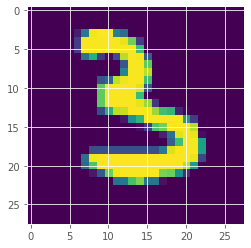

In [506]:
plt.imshow(X_train[y_train == 3][999])

In [507]:
classes = {}

for i in range(10):
    classes[f"df_{i}"] = X_train[:60000][y_train[:60000] == i]

In [508]:
for i in range(10):
    print(i, len(classes[f"df_{i}"]))

0 5923
1 6742
2 5958
3 6131
4 5842
5 5421
6 5918
7 6265
8 5851
9 5949


In [509]:
train_dataset_0 = tf.data.Dataset.from_tensor_slices(classes["df_0"]).shuffle(len(classes["df_0"])).batch(BATCH_SIZE)
train_dataset_1 = tf.data.Dataset.from_tensor_slices(classes["df_1"]).shuffle(len(classes["df_1"])).batch(BATCH_SIZE)
train_dataset_2 = tf.data.Dataset.from_tensor_slices(classes["df_2"]).shuffle(len(classes["df_2"])).batch(BATCH_SIZE)
train_dataset_3 = tf.data.Dataset.from_tensor_slices(classes["df_3"]).shuffle(len(classes["df_3"])).batch(BATCH_SIZE)
train_dataset_4 = tf.data.Dataset.from_tensor_slices(classes["df_4"]).shuffle(len(classes["df_4"])).batch(BATCH_SIZE)
train_dataset_5 = tf.data.Dataset.from_tensor_slices(classes["df_5"]).shuffle(len(classes["df_5"])).batch(BATCH_SIZE)
train_dataset_6 = tf.data.Dataset.from_tensor_slices(classes["df_6"]).shuffle(len(classes["df_6"])).batch(BATCH_SIZE)
train_dataset_7 = tf.data.Dataset.from_tensor_slices(classes["df_7"]).shuffle(len(classes["df_7"])).batch(BATCH_SIZE)
train_dataset_8 = tf.data.Dataset.from_tensor_slices(classes["df_8"]).shuffle(len(classes["df_8"])).batch(BATCH_SIZE)
train_dataset_9 = tf.data.Dataset.from_tensor_slices(classes["df_9"]).shuffle(len(classes["df_9"])).batch(BATCH_SIZE)

# Create GENERATOR

In [510]:
from tensorflow.keras import layers


def create_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7,7,256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

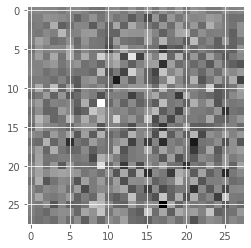

In [511]:
generator = create_generator_model()

noise = tf.random.normal([1,100])
img1 = generator(noise, training=False)

plt.imshow(img1[0, :, :, 0], cmap="gray")

# Create DISCRIMINATOR

In [512]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [513]:
discriminator = make_discriminator_model()
decision = discriminator(img1)
print (decision)

tf.Tensor([[0.00224565]], shape=(1, 1), dtype=float32)


# Loss Functions

In [514]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return 0.5*total_loss, real_loss, fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


In [515]:
generator_optimizer = tf.keras.optimizers.Adam(5e-5)
discriminator_optimizer = tf.keras.optimizers.Adam(5e-5)

# Checkpoints

In [516]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# Training Loop

In [517]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 256

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])


# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
#@tf.function
def train_step(images, generator, discriminator, epoch):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss, d_real_loss, d_fake_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return disc_loss, d_real_loss, d_fake_loss, gen_loss, generated_images


In [518]:
import time

def train(dataset, epochs, generator, discriminator, save_images_dict):

  for epoch in range(epochs):
    start = time.time()

    # acc = 0
    for image_batch in dataset:
      disc_loss, d_real_loss, d_fake_loss, gen_loss, gen_images = train_step(image_batch, generator, discriminator, epoch)
      save_images_dict[epoch] = gen_images

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    # print("Acc D:   ", acc/(len(dataset)))
    d_loss_plot.append(disc_loss)
    d_real_loss_plot.append(d_real_loss)
    d_fake_loss_plot.append(d_fake_loss)
    g_loss_plot.append(gen_loss)
    # acc_plot.append(disc_loss*0.5)

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)
  # return gen_loss_dict, dis_loss_dict

# Create Images and save them

In [519]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)
  

  fig = plt.figure(figsize=(4, 4))
  for i in range(16):
    # pred = np.asarray(predictions[i, :, :, 0] * 127.5 + 127.5)
    #curr_IS = calculate_inception_score(pred)
    # gen.append(pred)
    
    plt.subplot(4, 4, i+1)
    plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')
  plt.savefig('images/{}_image_at_epoch_{:04d}.png'.format(model.name, epoch))
  plt.show()


# Train GAN Models

## GAN_0

In [520]:
# Dict to save dicts with generated images per epoche
GAN_0 = {}

generator_0 = create_generator_model()
discriminator_0 = make_discriminator_model()

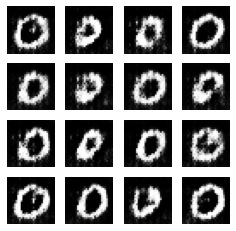

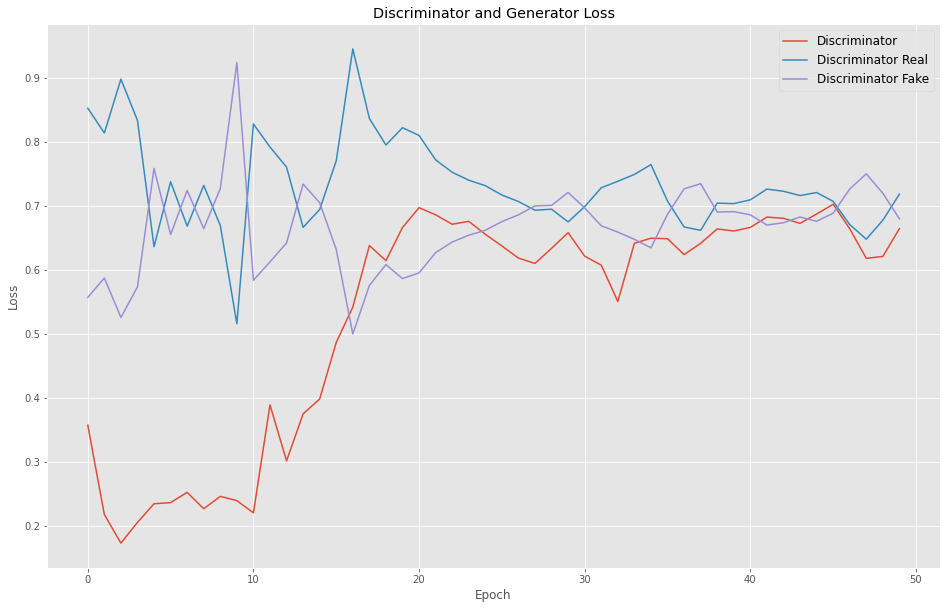

In [521]:
gen_loss_dict = {}
dis_loss_dict = {}
d_loss_plot = []
d_real_loss_plot = []
d_fake_loss_plot = []
g_loss_plot = []

train(train_dataset_0, 50, generator=generator_0, discriminator=discriminator_0, save_images_dict=GAN_0)

# Loss plots
plt.figure(figsize=(16,10))
# plt.plot(d_loss_plot)
plt.plot(d_real_loss_plot)
plt.plot(d_fake_loss_plot)
plt.plot(g_loss_plot)
plt.title("Discriminator and Generator Loss")
plt.ylabel("Loss", fontsize=12)
plt.xlabel("Epoch", fontsize=12)
plt.legend(["Discriminator", "Discriminator Real", "Discriminator Fake", "Generator"], fontsize=12)
plt.show()

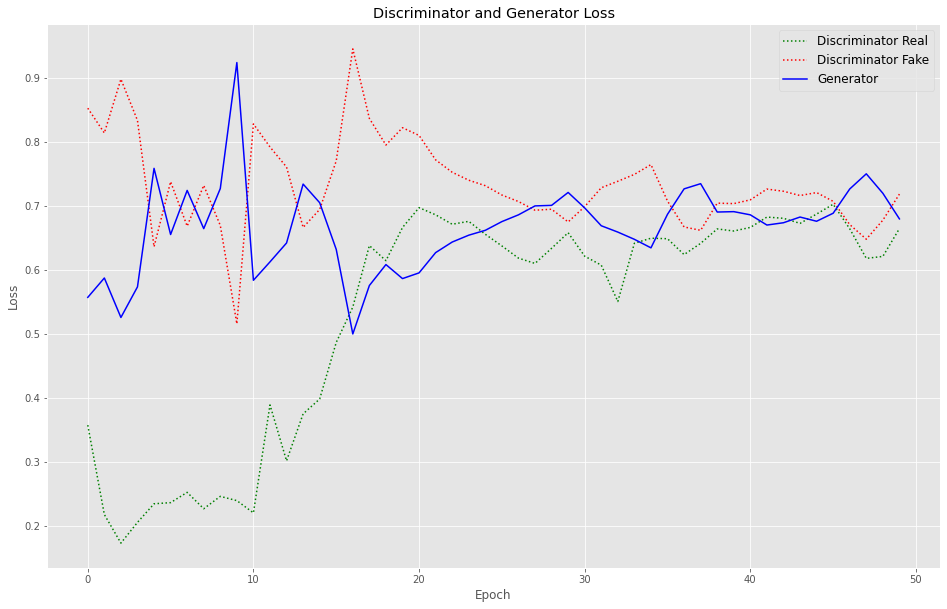

In [578]:
# Loss plots
plt.figure(figsize=(16,10))
# plt.plot(d_loss_plot)
plt.plot(d_real_loss_plot, "g:")
plt.plot(d_fake_loss_plot, "r:")
plt.plot(g_loss_plot, "b-")
plt.title("Discriminator and Generator Loss")
plt.ylabel("Loss", fontsize=12)
plt.xlabel("Epoch", fontsize=12)
plt.legend(["Discriminator Real", "Discriminator Fake", "Generator"], fontsize=12)
plt.show()

## GAN_0:   Train 1

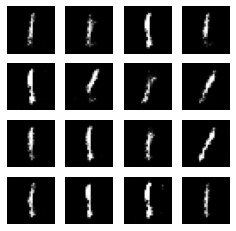

In [331]:
generator_01 = tf.keras.models.clone_model(generator_0)
generator_01.build((None, 30)) # replace 10 with number of variables in input layer
generator_01.compile(optimizer=generator_optimizer, loss='categorical_crossentropy')
generator_01.set_weights(generator_0.get_weights())

discriminator_01 = tf.keras.models.clone_model(discriminator_0)
discriminator_01.build((None, [28, 28, 1])) # replace 10 with number of variables in input layer
discriminator_01.compile(optimizer=discriminator_optimizer, loss='categorical_crossentropy')
discriminator_01.set_weights(discriminator_0.get_weights())


gen_loss_dict = {}
dis_loss_dict = {}
d_loss_plot = []
g_loss_plot = []

GAN_01 = {}
train(train_dataset_1, 30, generator=generator_01, discriminator=discriminator_01, save_images_dict=GAN_01)

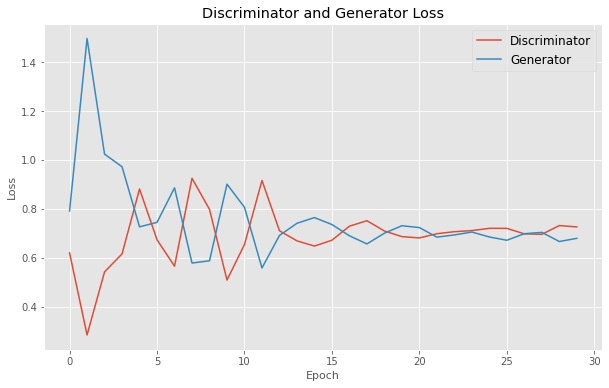

In [332]:
# Loss plots
plt.figure(figsize=(10,6))
plt.plot(d_loss_plot)
plt.plot(g_loss_plot)
plt.title("Discriminator and Generator Loss")
plt.ylabel("Loss", fontsize=11)
plt.xlabel("Epoch", fontsize=11)
plt.legend(["Discriminator", "Generator"], fontsize=12)
plt.style.use("ggplot")
plt.show()

## GAN_0:   Train 2

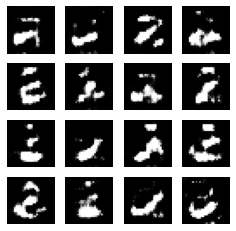

Time for epoch 31 is 3.6946730613708496 sec


KeyboardInterrupt: 

In [276]:
generator_02 = tf.keras.models.clone_model(generator_0)
generator_02.build((None, 100)) # replace 10 with number of variables in input layer
generator_02.compile(optimizer=generator_optimizer, loss='categorical_crossentropy')
generator_02.set_weights(generator_0.get_weights())

discriminator_02 = tf.keras.models.clone_model(discriminator_0)
discriminator_02.build((None, [28, 28, 1])) # replace 10 with number of variables in input layer
discriminator_02.compile(optimizer=discriminator_optimizer, loss='categorical_crossentropy')
discriminator_02.set_weights(discriminator_0.get_weights())


gen_loss_dict = {}
dis_loss_dict = {}
d_loss_plot = []
g_loss_plot = []

GAN_02 = {}
train(train_dataset_2, 100, generator=generator_02, discriminator=discriminator_02, save_images_dict=GAN_02)

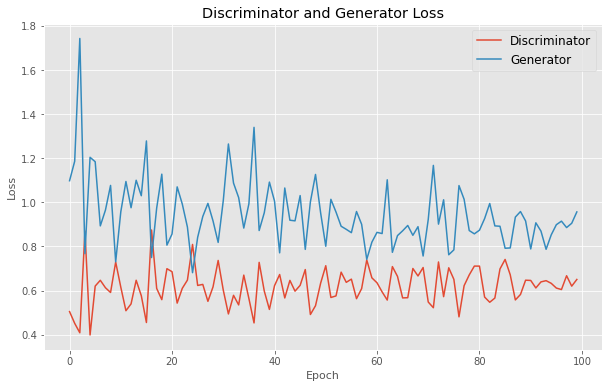

In [ ]:
# Loss plots
plt.figure(figsize=(10,6))
plt.plot(d_loss_plot)
plt.plot(g_loss_plot)
plt.title("Discriminator and Generator Loss")
plt.ylabel("Loss", fontsize=11)
plt.xlabel("Epoch", fontsize=11)
plt.legend(["Discriminator", "Generator"], fontsize=12)
plt.style.use("ggplot")
plt.show()

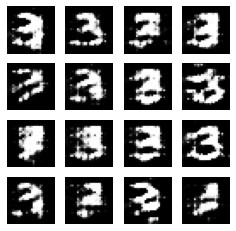

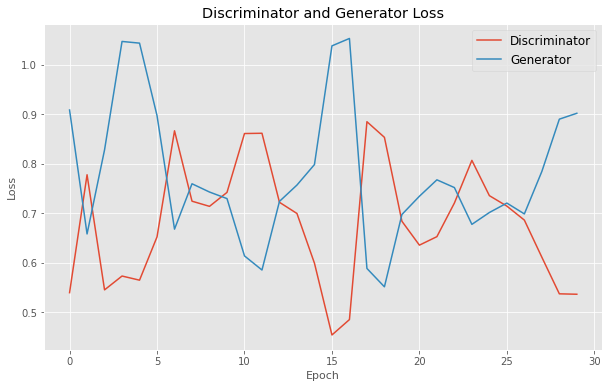

In [333]:
generator_03 = tf.keras.models.clone_model(generator_0)
generator_03.build((None, 100)) # replace 10 with number of variables in input layer
generator_03.compile(optimizer=generator_optimizer, loss='categorical_crossentropy')
generator_03.set_weights(generator_0.get_weights())

discriminator_03 = tf.keras.models.clone_model(discriminator_0)
discriminator_03.build((None, [28, 28, 1])) # replace 10 with number of variables in input layer
discriminator_03.compile(optimizer=discriminator_optimizer, loss='categorical_crossentropy')
discriminator_03.set_weights(discriminator_0.get_weights())


gen_loss_dict = {}
dis_loss_dict = {}
d_loss_plot = []
g_loss_plot = []

GAN_03 = {}
train(train_dataset_3, 30, generator=generator_03, discriminator=discriminator_03, save_images_dict=GAN_03)


# Loss plots
plt.figure(figsize=(10,6))
plt.plot(d_loss_plot)
plt.plot(g_loss_plot)
plt.title("Discriminator and Generator Loss")
plt.ylabel("Loss", fontsize=11)
plt.xlabel("Epoch", fontsize=11)
plt.legend(["Discriminator", "Generator"], fontsize=12)
plt.style.use("ggplot")
plt.show()

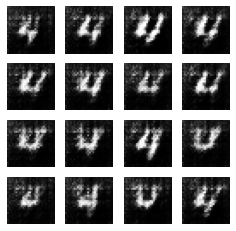

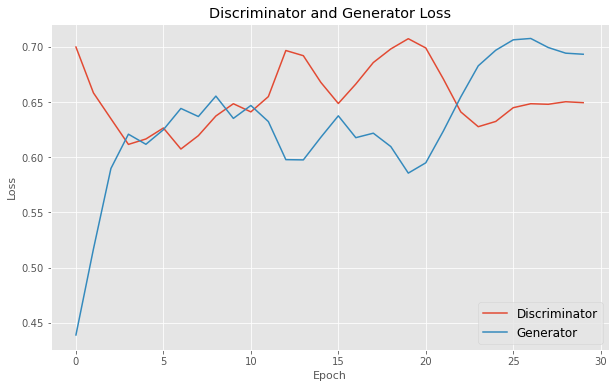

In [308]:
generator_04 = tf.keras.models.clone_model(generator_0)
generator_04.build((None, 100)) # replace 10 with number of variables in input layer
generator_04.compile(optimizer=generator_optimizer, loss='categorical_crossentropy')
generator_04.set_weights(generator_0.get_weights())

discriminator_04 = tf.keras.models.clone_model(discriminator_0)
discriminator_04.build((None, [28, 28, 1])) # replace 10 with number of variables in input layer
discriminator_04.compile(optimizer=discriminator_optimizer, loss='categorical_crossentropy')
discriminator_04.set_weights(discriminator_0.get_weights())


gen_loss_dict = {}
dis_loss_dict = {}
d_loss_plot = []
g_loss_plot = []

GAN_04 = {}
train(train_dataset_4, 30, generator=generator_04, discriminator=discriminator_04, save_images_dict=GAN_04)


# Loss plots
plt.figure(figsize=(10,6))
plt.plot(d_loss_plot)
plt.plot(g_loss_plot)
plt.title("Discriminator and Generator Loss")
plt.ylabel("Loss", fontsize=11)
plt.xlabel("Epoch", fontsize=11)
plt.legend(["Discriminator", "Generator"], fontsize=12)
plt.style.use("ggplot")
plt.show()

In [ ]:
generator_05 = tf.keras.models.clone_model(generator_0)
generator_05.build((None, 100)) # replace 10 with number of variables in input layer
generator_05.compile(optimizer=generator_optimizer, loss='categorical_crossentropy')
generator_05.set_weights(generator_0.get_weights())

discriminator_05 = tf.keras.models.clone_model(discriminator_0)
discriminator_05.build((None, [28, 28, 1])) # replace 10 with number of variables in input layer
discriminator_05.compile(optimizer=discriminator_optimizer, loss='categorical_crossentropy')
discriminator_05.set_weights(discriminator_0.get_weights())


gen_loss_dict = {}
dis_loss_dict = {}
d_loss_plot = []
g_loss_plot = []

GAN_05 = {}
train(train_dataset_5, 100, generator=generator_05, discriminator=discriminator_05, save_images_dict=GAN_05)


# Loss plots
plt.figure(figsize=(10,6))
plt.plot(d_loss_plot)
plt.plot(g_loss_plot)
plt.title("Discriminator and Generator Loss")
plt.ylabel("Loss", fontsize=11)
plt.xlabel("Epoch", fontsize=11)
plt.legend(["Discriminator", "Generator"], fontsize=12)
plt.style.use("ggplot")
plt.show()

In [ ]:
generator_06 = tf.keras.models.clone_model(generator_0)
generator_06.build((None, 100)) # replace 10 with number of variables in input layer
generator_06.compile(optimizer=generator_optimizer, loss='categorical_crossentropy')
generator_06.set_weights(generator_0.get_weights())

discriminator_06 = tf.keras.models.clone_model(discriminator_0)
discriminator_06.build((None, [28, 28, 1])) # replace 10 with number of variables in input layer
discriminator_06.compile(optimizer=discriminator_optimizer, loss='categorical_crossentropy')
discriminator_06.set_weights(discriminator_0.get_weights())


gen_loss_dict = {}
dis_loss_dict = {}
d_loss_plot = []
g_loss_plot = []

GAN_06 = {}
train(train_dataset_6, 100, generator=generator_06, discriminator=discriminator_06, save_images_dict=GAN_06)


# Loss plots
plt.figure(figsize=(10,6))
plt.plot(d_loss_plot)
plt.plot(g_loss_plot)
plt.title("Discriminator and Generator Loss")
plt.ylabel("Loss", fontsize=11)
plt.xlabel("Epoch", fontsize=11)
plt.legend(["Discriminator", "Generator"], fontsize=12)
plt.style.use("ggplot")
plt.show()

# SVM

In [68]:
from sklearn import svm, metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix



In [69]:
unique, counts = np.unique(y_train[:60000], return_counts=True)

In [70]:
for i in range(10):
    print(unique[i], counts[i])

0 5923
1 6742
2 5958
3 6131
4 5842
5 5421
6 5918
7 6265
8 5851
9 5949


In [71]:
svm_model = svm.SVC()
svm_model.fit(X_train.reshape(60000,784), y_train)

SVC()

In [72]:
predictions = svm_model.predict(X_test.reshape(10000, 784))
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.97      0.98      1032
           3       0.97      0.99      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.99      0.98      0.98       892
           6       0.99      0.99      0.99       958
           7       0.98      0.97      0.97      1028
           8       0.97      0.98      0.97       974
           9       0.97      0.96      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



In [73]:
np.asarray(GAN_0[2][0]).shape

(28, 28, 1)

In [334]:
# Transform images from dict to np.arrays 
G_0_arr = np.empty(shape=(30, 400, 28, 28, 1))
for i in range(30):
    G_0_arr[i] = np.asarray(GAN_0[i])

G_01_arr = np.empty(shape=(30, 400, 28, 28, 1))
for i in range(30):
    G_01_arr[i] = np.asarray(GAN_01[i])

G_03_arr = np.empty(shape=(30, 400, 28, 28, 1))
for i in range(30):
    G_03_arr[i] = np.asarray(GAN_03[i])
"""
G_04_arr = np.empty(shape=(30, 400, 28, 28, 1))
for i in range(30):
    G_04_arr[i] = np.asarray(GAN_04[i])


G_02_arr = np.empty(shape=(100, 256, 28, 28, 1))
for i in range(100):
    G_02_arr[i] = np.asarray(GAN_02[i])

G_07_arr = np.empty(shape=(50, 32, 28, 28, 1))
for i in range(50):
    G_07_arr[i] = np.asarray(GAN_07[i])
"""

'\nG_04_arr = np.empty(shape=(30, 400, 28, 28, 1))\nfor i in range(30):\n    G_04_arr[i] = np.asarray(GAN_04[i])\n\n\nG_02_arr = np.empty(shape=(100, 256, 28, 28, 1))\nfor i in range(100):\n    G_02_arr[i] = np.asarray(GAN_02[i])\n\nG_07_arr = np.empty(shape=(50, 32, 28, 28, 1))\nfor i in range(50):\n    G_07_arr[i] = np.asarray(GAN_07[i])\n'

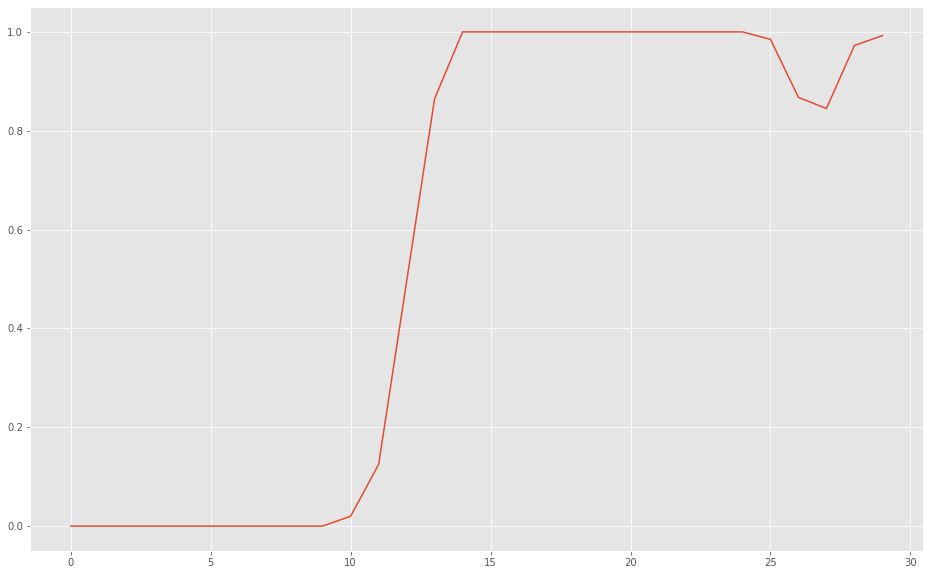

In [335]:
from sklearn.metrics import accuracy_score

preds = []
plt.figure(figsize=(16,10))
for i in range(30):
    predictions = svm_model.predict(G_0_arr[i].reshape(400,784))
    # classification_report(np.full(shape=256, fill_value=2), predictions)
    acc = accuracy_score(np.full(shape=400, fill_value=0), predictions)
    preds.append(acc)
plt.plot(preds)
plt.show()

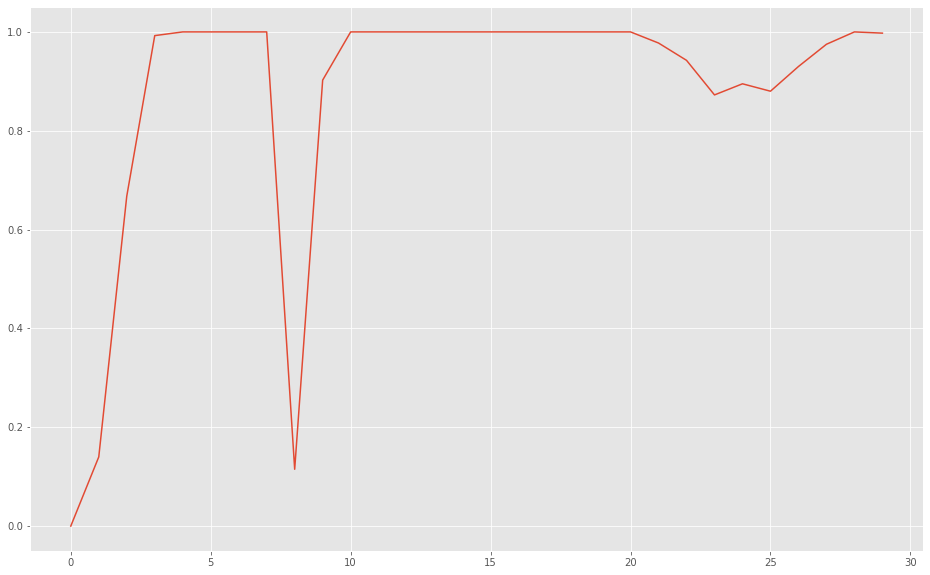

In [336]:
preds = []
plt.figure(figsize=(16,10))
for i in range(30):
    predictions = svm_model.predict(G_01_arr[i].reshape(400,784))
    # classification_report(np.full(shape=256, fill_value=2), predictions)
    acc = accuracy_score(np.full(shape=400, fill_value=1), predictions)
    preds.append(acc)
plt.plot(preds)
plt.show()

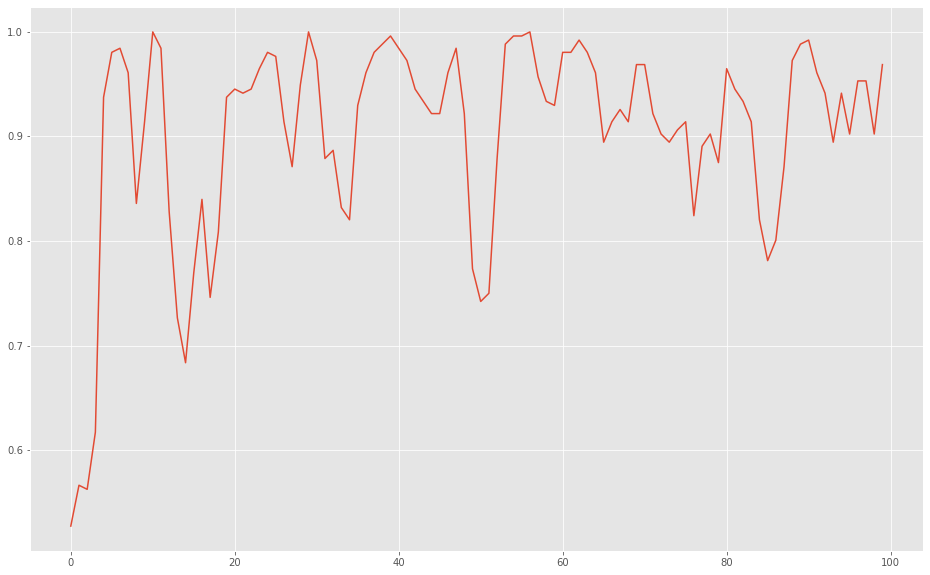

In [254]:
preds = []
plt.figure(figsize=(16,10))
for i in range(100):
    predictions = svm_model.predict(G_02_arr[i].reshape(256,784))
    # classification_report(np.full(shape=256, fill_value=2), predictions)
    acc = accuracy_score(np.full(shape=256, fill_value=2), predictions)
    preds.append(acc) 
plt.plot(preds)
plt.show()

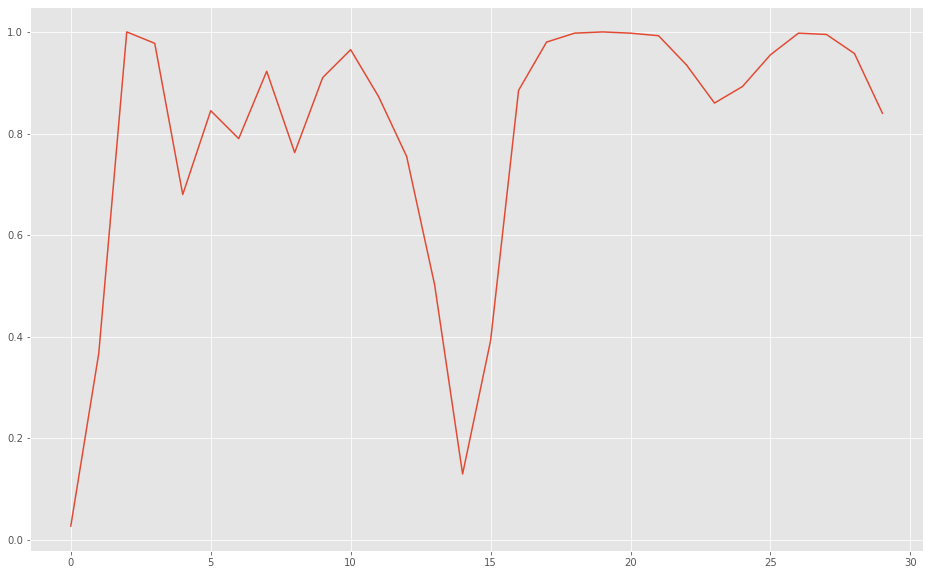

In [337]:
preds = []
plt.figure(figsize=(16,10))
for i in range(30):
    predictions = svm_model.predict(G_03_arr[i].reshape(400,784))
    # classification_report(np.full(shape=256, fill_value=2), predictions)
    acc = accuracy_score(np.full(shape=400, fill_value=3), predictions)
    preds.append(acc)
plt.plot(preds)
plt.show()

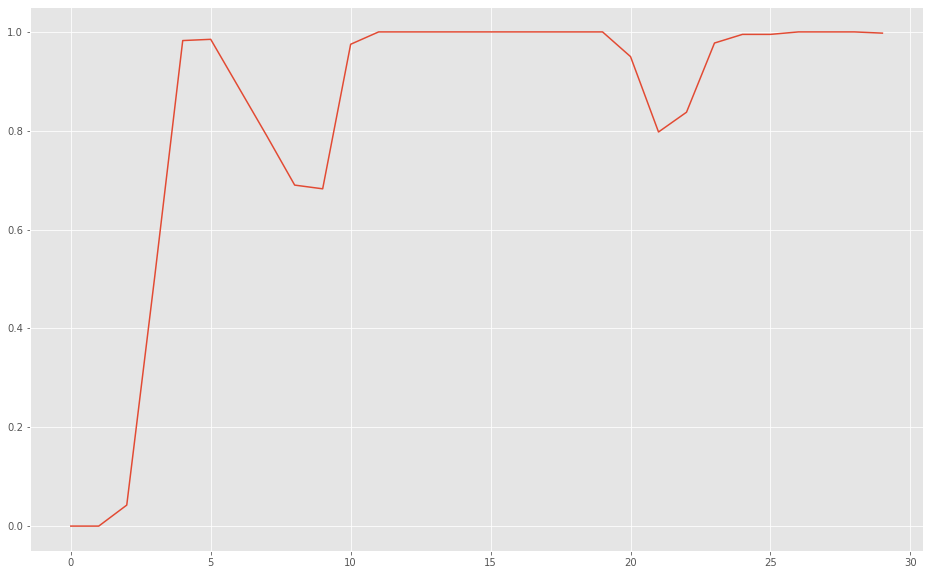

In [311]:
preds = []
plt.figure(figsize=(16,10))
for i in range(30):
    predictions = svm_model.predict(G_04_arr[i].reshape(400,784))
    # classification_report(np.full(shape=256, fill_value=2), predictions)
    acc = accuracy_score(np.full(shape=400, fill_value=4), predictions)
    preds.append(acc)
plt.plot(preds)
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
 
# defining parameter range
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}
 
grid = GridSearchCV(svm.SVC(), param_grid, refit=True, verbose=2)
 
# fitting the model for grid search
grid.fit(X_train[:10000].reshape(10000, 784), y_train[:10000])

In [ ]:
# print best parameter after tuning
print(grid.best_params_)
 
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

In [ ]:
X_t = X_test[:1677]
grid_predictions = grid.predict(X_t.reshape(1677,784))
print(classification_report(y_test[:1677], grid_predictions))

In [ ]:
svm2 = svm.SVC(gamma=0.1)
svm2.fit(X_train[:10000].reshape(10000,784), y_train[:10000])
predictions2 = svm2.predict(X_test[:1667].reshape(1667, 784))
print(classification_report(y_test[:1667], predictions2))

# cGAN (https://www.kaggle.com/jjjokkker/cgan-for-mnist)

In [ ]:
from __future__ import division, print_function
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
import itertools
import time
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import cv2
from PIL import Image
from sklearn.metrics import confusion_matrix
from keras.preprocessing import image
from keras.models import Model, Sequential
from keras.layers import Activation, Dense, Flatten, GlobalAveragePooling2D, BatchNormalization, Dropout, Conv2D, Conv2DTranspose, AveragePooling2D, MaxPooling2D, UpSampling2D, Input, Reshape, Lambda, merge, Concatenate, Subtract, Reshape, multiply
from keras.layers import Embedding, ZeroPadding2D
from keras.regularizers import l2
from keras.layers.advanced_activations import LeakyReLU
from keras import backend as K
from tensorflow.keras.optimizers import Nadam, Adam, SGD
from tensorflow.keras.metrics import categorical_accuracy, binary_accuracy
from tensorflow.keras.callbacks import Callback, History
import tensorflow as tf
import pandas as pd
import glob
import PIL
from sys import getsizeof
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib.ticker import MaxNLocator
from sklearn.utils import class_weight
from keras.datasets import mnist

In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# Image shape information
img_rows = X_train.shape[1]
img_cols = X_train.shape[2]
if len(X_train.shape) == 4:
    channels = X_train.shape[3]
else:
    channels = 1
img_shape = (img_rows, img_cols, channels)
num_classes = 10
latent_dim = 100
optimizer = Adam(0.0002, 0.5)

In [ ]:
def generator():
    model = Sequential()
    model.add(Dense(256, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))
    model.summary()
    noise = Input(shape=(latent_dim,))
    label = Input(shape=(1,), dtype='int32')
    label_embedding = Flatten()(Embedding(num_classes, latent_dim)(label))
    model_input = multiply([noise, label_embedding])
    img = model(model_input)
    return Model([noise, label], img)

In [ ]:
def discriminator():
    model = Sequential()
    model.add(Dense(512, input_dim=np.prod(img_shape)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    img = Input(shape=img_shape)
    label = Input(shape=(1,), dtype='int32')
    label_embedding = Flatten()(Embedding(num_classes, np.prod(img_shape))(label))
    flat_img = Flatten()(img)
    model_input = multiply([flat_img, label_embedding])
    validity = model(model_input)
    return Model([img, label], validity)

In [ ]:
discriminator = discriminator()
discriminator.compile(loss=['binary_crossentropy'], optimizer=optimizer, metrics=['accuracy'])
# Build the generator
generator = generator()
# The generator takes noise and the target label as input
# and generates the corresponding digit of that label
noise = Input(shape=(latent_dim,))
label = Input(shape=(1,))
img = generator([noise, label])
# For the combined model we will only train the generator
discriminator.trainable = False
# The discriminator takes generated image as input and determines validity
# and the label of that image
valid = discriminator([img, label])
# The combined model  (stacked generator and discriminator)
# Trains generator to fool discriminator
combined = Model([noise, label], valid)
combined.compile(loss=['binary_crossentropy'], optimizer=optimizer)

In [ ]:
def sample_images(epoch, train_on=None):
    r, c = 2, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    if train_on:
        sampled_labels = np.full(10, train_on).reshape(-1, 1)
    else:
        sampled_labels = np.arange(0, 10).reshape(-1, 1)

    gen_imgs = generator.predict([noise, sampled_labels])

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
            axs[i,j].set_title("Digit: %d" % sampled_labels[cnt])
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("images/%d.png" % epoch)
    plt.close()

In [ ]:
epochs=5000
batch_size=32
sample_interval=500

In [ ]:
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis=3)
y_train = y_train.reshape(-1, 1)

# Adversarial ground truths
valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))    

# Declaring empty lists to save the losses for plotting
d_loss_plot = []
g_loss_plot = []
acc_plot = []

In [ ]:
X_3 = []
X_8 = []
for i in range(len(X_train)):
    if y_train[i] == 3:
        X_3.append(i)
    if y_train[i] == 8:
        X_8.append(i)

In [ ]:
imgs, labels = X_train[X_3][idx], y_train[X_3][idx]
labels.shape

In [ ]:
for epoch in range(epochs):
    #Training the Discriminator
    # Select a random half batch of images
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs, labels = X_train[idx], y_train[idx]
    # Sample noise as generator input
    noise = np.random.normal(0, 1, (batch_size, 100))
    # Generate a half batch of new images
    gen_imgs = generator.predict([noise, labels])
    # Train the discriminator
    d_loss_real = discriminator.train_on_batch([imgs, labels], valid)
    d_loss_fake = discriminator.train_on_batch([gen_imgs, labels], fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    #Training the Generator
    # Condition on labels
    sampled_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)
    # Train the generator
    g_loss = combined.train_on_batch([noise, sampled_labels], valid)
    # Saving the Discriminator and Generator losses and accuracy for plotting
    d_loss_plot.append(d_loss[0])
    g_loss_plot.append(g_loss)
    acc_plot.append(d_loss[1])
    
    # Plot the progress every 100 epochs
    if epoch % 500 == 0:
        print ("%d/%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, epochs, d_loss[0], 100*d_loss[1], g_loss))
        samples = 10
        z = np.random.normal(loc=0, scale=1, size=(samples, latent_dim))
        labels = np.arange(0, 10).reshape(-1, 1)
        
        x_fake = generator.predict([z, labels])
        for k in range(samples):
            plt.subplot(2, 5, k+1)
            plt.imshow(x_fake[k].reshape(28, 28), cmap='gray')
            plt.xticks([])
            plt.yticks([])
        plt.tight_layout()
        plt.show()
    # Saving generated image samples at every sample interval
    if epoch % sample_interval == 0:
        sample_images(epoch)

def train(gen, disc, epochs, X_train, y_train, train_on=None):
    if train_on:
        print(f"** TRAINING ON IMAGES WITH LABEL  {train_on} **")

    for epoch in range(epochs):
        #Training the Discriminator

        # Select a random half batch of images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs, labels = X_train[idx], y_train[idx]

        # Sample noise as generator input
        noise = np.random.normal(0, 1, (batch_size, 100))

        # Generate a half batch of new images
        gen_imgs = gen.predict([noise, labels])

        # Train the discriminator
        d_loss_real = disc.train_on_batch([imgs, labels], valid)
        d_loss_fake = disc.train_on_batch([gen_imgs, labels], fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


        #Training the Generator

        # Condition on label
        sampled_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)
        # Train the generator
        g_loss = combined.train_on_batch([noise, sampled_labels], valid)


        # Saving the Discriminator and Generator losses and accuracy for plotting
        d_loss_plot.append(d_loss[0])
        g_loss_plot.append(g_loss)
        acc_plot.append(d_loss[1])

        # Plot the progress every 500 epochs
        if epoch % 500 == 0:
            print ("%d/%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, epochs, d_loss[0], 100*d_loss[1], g_loss))

            samples = 10
            z = np.random.normal(loc=0, scale=1, size=(samples, latent_dim))
            labels = np.arange(0, 10).reshape(-1, 1)
            
            x_fake = gen.predict([z, labels])

            for k in range(samples):
                plt.subplot(2, 5, k+1)
                plt.imshow(x_fake[k].reshape(28, 28), cmap='gray')
                plt.xticks([])
                plt.yticks([])

            plt.tight_layout()
            plt.show()

        # Saving generated image samples at every sample interval
        if epoch % sample_interval == 0:
            if train_on:
                sample_images(epoch, generator=gen, train_on=train_on)
            else:
                sample_images(epoch, generator=gen)

train(generator, discriminator, epochs=5000, X_train=X_train, y_train=y_train)

In [ ]:
plt.plot(acc_plot)

plt.title('Discriminator accuracy')

plt.ylabel('accuracy')

plt.xlabel('epoch')

plt.show()



# Loss plots

plt.plot(d_loss_plot)

plt.plot(g_loss_plot)

plt.title('Losses')

plt.ylabel('loss')

plt.xlabel('epoch')

plt.legend(['Discriminator', 'Generator'])

plt.show()


# Inceptions Score (IS)

In [ ]:
from numpy import expand_dims
from numpy import log
from numpy import mean
from numpy import exp
 
# calculate the inception score for p(y|x)
def calculate_inception_score(p_yx, eps=1E-16):
	# calculate p(y)
	p_y = expand_dims(p_yx.mean(axis=0), 0)
	# kl divergence for each image
	kl_d = p_yx * (log(p_yx + eps) - log(p_y + eps))
	# sum over classes
	sum_kl_d = kl_d.sum(axis=1)
	# average over images
	avg_kl_d = mean(sum_kl_d)
	# undo the logs
	is_score = exp(avg_kl_d)
	return is_score